# Data Pre-processing

Converting raw data into ingredients fit for our strategy recipe is an annoying yet necessary work. Here's how I cleaned and processed data for this project.

Ultimately, we want these data:

1. Industry Index Price Series (Quarterly)
2. Industry Index Total Return Series (Quarterly)
3. Industry Index Earnings Series (Quarterly)

In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from datetime import datetime, timedelta
from xquant.util import *
import seaborn as sns

In [2]:
df_div = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/dividends.csv', parse_dates=['announced'], dtype={'ticker':str})
df_price = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/price.csv', index_col=['date'], parse_dates=['date'])
df_mktcap = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/market_cap.csv', index_col=['date'], parse_dates=['date'])
df_comp = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/WIND_II_index_comp.csv', parse_dates=['included', 'excluded'])
# df_map = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/ticker_map.csv', index_col=['key'])
df_idx = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/WIND_II_industry_index.csv', index_col=['Date'], parse_dates=['Date'])

In [3]:
# time range for back test
START = datetime(2000,2,1)
END = datetime(2020,12,31)

## Clean dividend data

In [4]:
df_div['ticker'] = df_div['ticker'].apply(add_suffix) # convert ticker symbol into standard format (e.g. 000001.SZ)

In [5]:
df_div.dropna(subset=['announced'], inplace=True)

## Clean Index Composition Data

In [6]:
# map symbols to actual names of industry
# df_comp['industry'] = df_comp['industry'].apply(lambda x: df_map.at[x,'value'])

In [7]:
# if stock is still a member of the index, set excluded time to a future data far away
df_comp['excluded'].fillna(pd.Timestamp('20991231'), inplace=True)

In [8]:
df_comp.dropna(subset=['included'], inplace=True)

## Calculate Financial Metrics for an Index

Very often we would need to look at certain metrics of an index, such as earnings and dividends. In a market capitalization weighted indices with $n$ components, its metric $m$ is calculated by:

$\sum^{n}_{i=1} w_{i} \cdot m_{i}$

where $w$ is the weight of component $i$ in the index (i.e. market cap of component $i$ divided by sum of market cap for all components).

### First calculate the scale (i.e. multiplier) for each industry index at a certain date

In [9]:
def get_scale(date) -> dict:
    d = dict.fromkeys(df_idx.columns,[])
    for i in df_idx.columns:
        total = 0
        f = get_index_weights(df_mktcap, df_comp.query(f"industry=='{i}'"), pd.Timestamp(date))
        for s in f.index:
            local_sum = f[s] * df_price.at[pd.Timestamp(date), s]
            if pd.notna(local_sum):
                total += local_sum
        if total != 0:            
            d[i] = df_idx.at[date,i]/total
        else:
            d[i] = np.nan
    return d

### Then calculate the quarterly weighted sum of a metric

In [10]:
def get_weighted_sum_div(start, end, df, sum_col, date_col):
    begin = time.time()
    days = [closest_trading_day(day, df_price.index, 'ffill') for day in quarter_generator(start,end)]
    df_sum = pd.DataFrame(index=days, columns=df_idx.columns)

    for day in tqdm(df_sum.index):
        if day.quarter == 1:
            look_up = (day.year-1, 4)
        else:
            look_up = (day.year, day.quarter-1)

        scale_dict = get_scale(day)
        for industry in df_idx.columns:
            w = get_index_weights(df_mktcap, df_comp.query(f"industry=='{industry}'"), day)

            weighted = {}
            multiplier = scale_dict[industry]

            for stock in w.index:
                s = quarter_sum(ticker=stock, quarter=look_up, df=df, sum_col=sum_col, date_col=date_col)
                weighted_sum = w[stock] * s
                weighted[stock] = weighted_sum

            df_sum.at[day, industry] = pd.Series(weighted, dtype=float).sum() * multiplier
    
    print(f'\ncomputation completed in {time.time()-begin} seconds.')
    return df_sum

### Quarterly Prices

This one is easy, `xquant` has a function for exactly this.

In [11]:
df_idx_q = quarter_begin(df_idx, START, END)

In [12]:
df_idx_q.head()

,Energy,Materials,Capital Goods,Commercial & Professional Services,Transportation,Automobiles & Components,Consumer Durables & Apparel,Consumer Services,Media,Retailing,...,"Pharmaceuticals, Biotechnology & Life Sciences",Banks,Diversified Financials,Insurance,Real Estate,Software & Services,Technology Hardware & Equipment,Semiconductors & Semiconductor Equipment,Communication Services,Utilities
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-03,1450.6584,1334.9933,1400.2723,2008.3654,1283.0132,1293.2301,1331.6353,1673.4393,1704.6654,1511.5863,...,1301.8201,1039.3033,1428.8860,1000.0,1465.1221,1438.8040,1396.1495,1187.6190,2002.7550,1314.1241
2000-07-03,1547.7512,1465.1349,1445.6331,1653.9572,1435.6813,1444.9443,1368.2540,1722.3989,1392.5624,1510.0586,...,1484.1367,993.4025,1328.5554,1000.0,1494.7897,1456.1425,1414.6483,1164.5901,2066.8048,1582.6605
2000-10-09,1645.2645,1519.2216,1483.5894,1684.3151,1384.5245,1464.8317,1397.3405,1743.2468,1346.8025,1551.5781,...,1448.4971,932.6462,1510.5999,1000.0,1435.3936,1505.6890,1423.9452,1138.4640,1494.9085,1534.3790
2001-01-02,1757.2162,1694.0760,1605.7705,1747.6825,1496.8737,1664.9088,1486.3104,1898.4481,1477.6908,1682.3978,...,1676.2916,905.4969,1572.6841,1000.0,1566.1747,1593.1594,1533.1340,1296.2286,1744.5218,1667.5796
2001-04-02,1786.1517,1731.8992,1569.7546,1685.9713,1496.7267,1751.2046,1485.3275,1838.9661,1408.0161,1662.3099,...,1619.8064,991.8091,1488.8676,1000.0,1530.1825,1415.5372,1404.1416,1169.8533,1594.7535,1680.7876


### Quarterly Dividends

In [13]:
df_div_q = get_weighted_sum_div(START, END, df_div, 'div_per_share', 'announced')

100%|██████████| 83/83 [09:38<00:00,  6.97s/it]
computation completed in 578.3459775447845 seconds.



In [14]:
df_div_q = df_div_q.fillna(0).set_index(df_idx_q.index)

In [15]:
df_div_q.head()

,Energy,Materials,Capital Goods,Commercial & Professional Services,Transportation,Automobiles & Components,Consumer Durables & Apparel,Consumer Services,Media,Retailing,...,"Pharmaceuticals, Biotechnology & Life Sciences",Banks,Diversified Financials,Insurance,Real Estate,Software & Services,Technology Hardware & Equipment,Semiconductors & Semiconductor Equipment,Communication Services,Utilities
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-03,0.000000,0.066754,0.016803,0.0,0.000000,0.071430,0.023637,0.000000,0.000000,0.003382,...,0.000000,1.131109,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2000-07-03,0.000000,0.029840,0.000000,0.0,0.000000,0.108683,0.000000,0.000000,0.000000,0.000000,...,0.116029,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2000-10-09,0.038748,1.428441,0.109757,0.0,0.406385,0.799850,0.052425,2.275024,0.000000,0.028048,...,0.838835,0.000000,0.933248,0.0,0.096230,0.0,0.172700,4.310827,0.000000,2.057808
2001-01-02,0.008106,0.397470,0.109519,0.0,0.303817,1.282433,0.032703,0.000000,1.362292,0.027061,...,1.003506,0.487519,0.425785,0.0,0.353097,0.0,0.088721,0.000000,2.123415,1.386191
2001-04-02,0.000000,0.093654,0.000000,0.0,0.000000,0.086521,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.025915,0.0,0.017057,0.000000,0.000000,0.014427


### Quarterly Total Return Series

Simply add the price series and dividend series together and normalize start date to 1.

In [16]:
df_total_rtn_q = df_idx_q + df_div_q.fillna(0)

In [17]:
df_total_rtn_q = df_idx_q + df_div_q.fillna(0).set_index(df_idx_q.index)

In [18]:
df_total_rtn_q.head()

,Energy,Materials,Capital Goods,Commercial & Professional Services,Transportation,Automobiles & Components,Consumer Durables & Apparel,Consumer Services,Media,Retailing,...,"Pharmaceuticals, Biotechnology & Life Sciences",Banks,Diversified Financials,Insurance,Real Estate,Software & Services,Technology Hardware & Equipment,Semiconductors & Semiconductor Equipment,Communication Services,Utilities
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-03,1450.658400,1335.060054,1400.289103,2008.3654,1283.013200,1293.301530,1331.658937,1673.439300,1704.665400,1511.589682,...,1301.820100,1040.434409,1428.886000,1000.0,1465.122100,1438.8040,1396.149500,1187.619000,2002.755000,1314.124100
2000-07-03,1547.751200,1465.164740,1445.633100,1653.9572,1435.681300,1445.052983,1368.254000,1722.398900,1392.562400,1510.058600,...,1484.252729,993.402500,1328.555400,1000.0,1494.789700,1456.1425,1414.648300,1164.590100,2066.804800,1582.660500
2000-10-09,1645.303248,1520.650041,1483.699157,1684.3151,1384.930885,1465.631550,1397.392925,1745.521824,1346.802500,1551.606148,...,1449.335935,932.646200,1511.533148,1000.0,1435.489830,1505.6890,1424.117900,1142.774827,1494.908500,1536.436808
2001-01-02,1757.224306,1694.473470,1605.880019,1747.6825,1497.177517,1666.191233,1486.343103,1898.448100,1479.053092,1682.424861,...,1677.295106,905.984419,1573.109885,1000.0,1566.527797,1593.1594,1533.222721,1296.228600,1746.645215,1668.965791
2001-04-02,1786.151700,1731.992854,1569.754600,1685.9713,1496.726700,1751.291121,1485.327500,1838.966100,1408.016100,1662.309900,...,1619.806400,991.809100,1488.867600,1000.0,1530.208415,1415.5372,1404.158657,1169.853300,1594.753500,1680.802027


Might as well see what it looks like...

In [19]:
df_total_rtn_q_plot = df_total_rtn_q.div(df_total_rtn_q.loc[df_total_rtn_q.index[0]]).mul(100)

<AxesSubplot:xlabel='Date'>

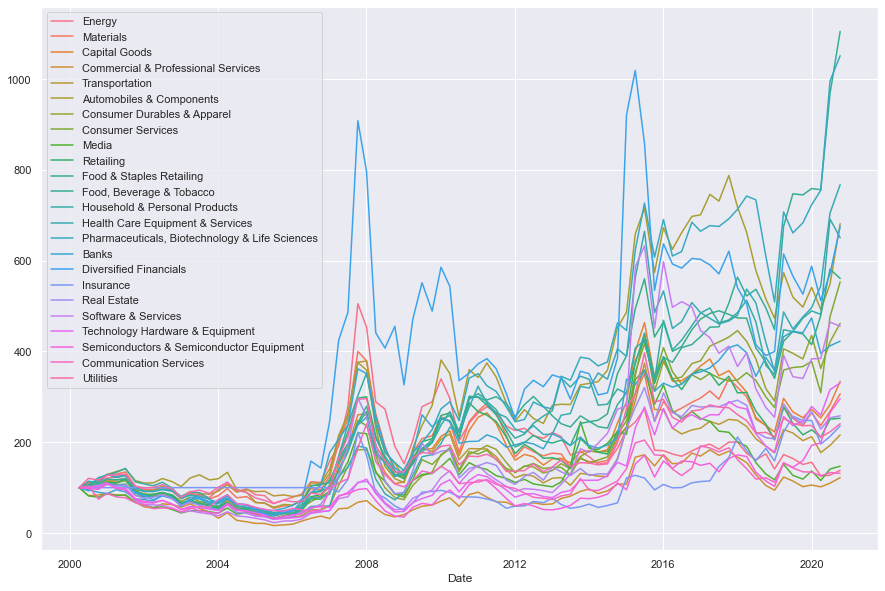

In [20]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(data=df_total_rtn_q_plot, dashes=False)

### Quarterly Earnings Series

In [21]:
df_earnings = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/earnings.csv', parse_dates=['announced'], usecols=['ticker','announced','NPAP'])

In [22]:
df_earnings['ticker'] = df_earnings['ticker'].astype(str).apply(add_suffix)

Need to tweak `get_weighted_sum_div` a little bit.

In [23]:
def get_weighted_sum_earnings(start, end, df, sum_col, date_col):
    begin = time.time()
    days = [closest_trading_day(day, df_price.index, 'ffill') for day in quarter_generator(start,end)]
    df_sum = pd.DataFrame(index=days, columns=df_idx.columns)

    for day in tqdm(df_sum.index):
        if day.quarter == 1:
            look_up = (day.year-1, 4)
        else:
            look_up = (day.year, day.quarter-1)

        scale_dict = get_scale(day)
        for industry in df_idx.columns:
            w = get_index_weights(df_mktcap, df_comp.query(f"industry=='{industry}'"), day)

            weighted = {}
            multiplier = scale_dict[industry]

            for stock in w.index:
                try:
                    eps = get_eps(
                        ticker=stock, 
                        date=day, 
                        df_price=df_price, 
                        df_mktcap=df_mktcap, 
                        df_earnings=df_earnings, 
                        earnings_col='NPAP', 
                        date_col='announced')
                except IndexError:
                    eps = 0
                weighted_sum = w[stock] * eps
                weighted[stock] = weighted_sum

            df_sum.at[day, industry] = pd.Series(weighted, dtype=float).sum() * multiplier
    
    print(f'\ncomputation completed in {time.time()-begin} seconds.')
    return df_sum

In [24]:
df_earnings_q = get_weighted_sum_earnings(START, END, df_earnings, 'NPAP', 'announced')

100%|██████████| 83/83 [24:23<00:00, 17.64s/it]
computation completed in 1463.9100334644318 seconds.



In [25]:
df_earnings_q = df_earnings_q.set_index(df_div_q.index)

In [26]:
df_earnings_q.head()

,Energy,Materials,Capital Goods,Commercial & Professional Services,Transportation,Automobiles & Components,Consumer Durables & Apparel,Consumer Services,Media,Retailing,...,"Pharmaceuticals, Biotechnology & Life Sciences",Banks,Diversified Financials,Insurance,Real Estate,Software & Services,Technology Hardware & Equipment,Semiconductors & Semiconductor Equipment,Communication Services,Utilities
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-03,5.97208,15.186,8.75186,4.17867,17.6148,11.2881,8.60967,14.7191,10.9342,45.2711,...,18.1518,9.65532,26.7481,NaN,13.4181,17.2306,26.9388,12.7198,23.3074,32.3229
2000-07-03,12.6073,17.2706,13.257,26.4975,26.1415,22.1265,12.9846,17.0353,16.973,44.3763,...,20.8562,19.6164,28.6601,NaN,17.1214,19.077,32.3687,14.0423,23.3074,35.9458
2000-10-09,5.49707,10.0808,17.071,2.24583,15.8579,-0.767614,4.32929,7.13596,11.0528,25.046,...,11.7517,6.72236,14.4605,NaN,7.21891,9.98955,18.6929,5.42361,6.15446,21.3625
2001-01-02,5.56003,9.62952,16.5014,2.11892,16.1629,-0.786495,3.75388,7.15831,10.8558,26.9182,...,12.0659,6.04897,16.0156,NaN,7.1184,8.74356,19.6143,5.23311,6.15446,20.5104
2001-04-02,32.9539,19.4633,20.6298,3.45425,31.1362,7.62934,2.98753,14.8937,21.4131,51.5407,...,23.651,5.87196,22.0428,NaN,15.87,14.6144,20.9677,11.8068,11.7295,36.5745


### Finally, scale earnings

In [27]:
df_earnings_q = df_earnings_q * (df_total_rtn_q / df_idx_q)

## Adjusting for inflation

In [28]:
df_cpi = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/cpi.csv', parse_dates=['Date'], index_col=['Date'])

In [29]:
df_cpi = df_cpi.loc[START:END]
df_cpi = df_cpi / df_cpi['CPI'][0]
df_cpi.set_index(df_earnings_q.index, inplace=True)

In [30]:
df_cpi.head()

,CPI
Date,
2000-04-03,1.000000
2000-07-03,0.996567
2000-10-09,1.014185
2001-01-02,1.024880
2001-04-02,1.015672


In [31]:
for col in df_earnings_q.columns:
    df_earnings_q[col] = df_earnings_q[col] / df_cpi['CPI']
    df_total_rtn_q[col] = df_total_rtn_q[col] / df_cpi['CPI']
    df_idx_q[col] = df_idx_q[col] / df_cpi['CPI']
    df_div_q[col] = df_div_q[col] / df_cpi['CPI']

In [32]:
df_div_q.to_csv('data\\quarterly_dividends_II.csv')
df_idx_q.to_csv('data\\quarterly_prices_II.csv')
df_total_rtn_q.to_csv('data\\quarterly_total_returns_II.csv')
df_earnings_q.to_csv('data\\quarterly_earnings_II.csv')